# 0.0 IMPORTS

In [70]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
from IPython.core.display     import HTML
from scipy                    import stats         as ss
from sklearn                  import preprocessing as pp

## 0.1 Functions

In [55]:
#configurando o notebook

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    sns.set()
    
jupyter_settings()

def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('insurance_cross_sell.csv')

# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw

## 1.1 Drop Colums

In [5]:
#dropando colunas duplicadas do DF
df1 = df1.drop(columns=['id.1', 'id.2'], axis=1)

## 1.2 Data Dimensions

In [6]:
#verificando tamanho do DF
df1.shape

(381109, 12)

## 1.3 Data Types

In [7]:
#verificando tipos de variáveis
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [8]:
#verificando possibilidade de valores NA
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Descriptive Statistical 

### 1.5.1 Numerical Attributes

In [9]:
# Central Tendency - mean, median
# Dispersion - std, min, max, range, skew, kurtosis
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [10]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [11]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,381109.000,381108.000,190555.000,190555.000,110016.692,-0.000,-1.200
1,age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
2,region_code,0.000,52.000,52.000,26.389,28.000,13.230,-0.115,-0.868
3,policy_sales_channel,1.000,163.000,162.000,112.034,133.000,54.204,-0.900,-0.971
4,driving_license,0.000,1.000,1.000,0.998,1.000,0.046,-21.595,464.354
5,previously_insured,0.000,1.000,1.000,0.458,0.000,0.498,0.168,-1.972
6,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.132,1.766,34.005
7,vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201
8,response,0.000,1.000,1.000,0.123,0.000,0.328,2.302,3.299


### 1.5.1 Categorical Attributes

In [12]:
#verificando os atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [13]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


# 2.0  FEATURE ENGINEERING

In [14]:
df2 = df1

In [15]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'bellow_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 DATA FILTERING

In [16]:
df3 = df2

# 4.0 EDA

In [17]:
df4 = df3

**Hipothesis List:**

1 - Homens são mais propensos a comprar seguro do carro do que as mulheres

2 - Pessoas acima de 40 anos são mais propensos a comprar o seguro do carro

3 - Pessoas que pagam mais de 50k por ano em seguro saúde são mais propensos a comprar também o seguro do carro

4 - Homens de até 30 anos não tendem a se interessar pelo seguro do carro

5 - Donos de carros cujo a idade do veículo é menor que  1 ano tendem a comprar o seguro de carro

6 - Clientes há mais de 100 dias do seguro saúde tendem a ter interesse no seguro do carro

7 - Homens com mais de 50 anos que nunca tiveram seguro de carro não tendem a ter interesse em adquirir um

8 - Clientes que pagam até 30 mil de seguro saúde por ano não tendem a ter interesse no seguro do carro

## 4.1 Univariate Analysis

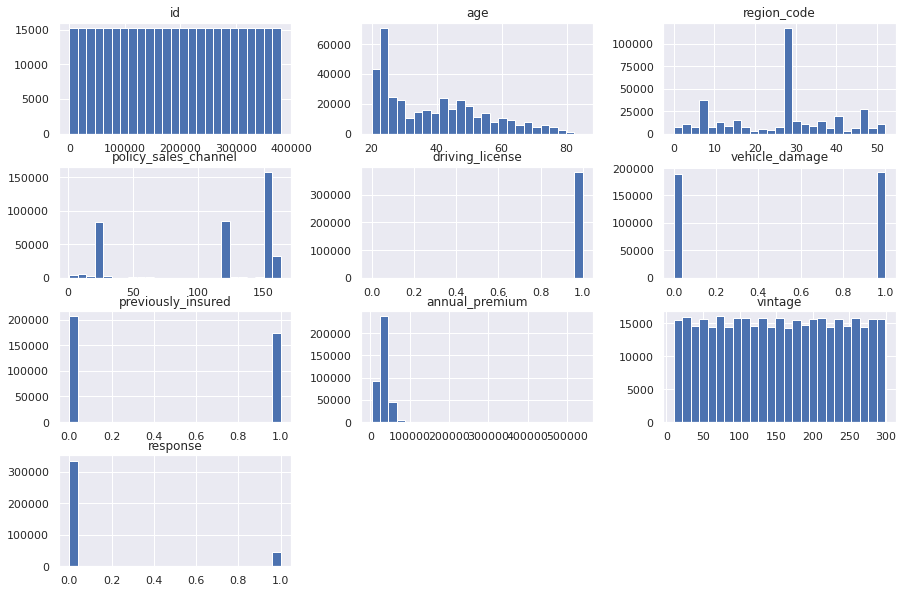

In [18]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(figsize=(15,10), bins=25);

<AxesSubplot:xlabel='response', ylabel='age'>

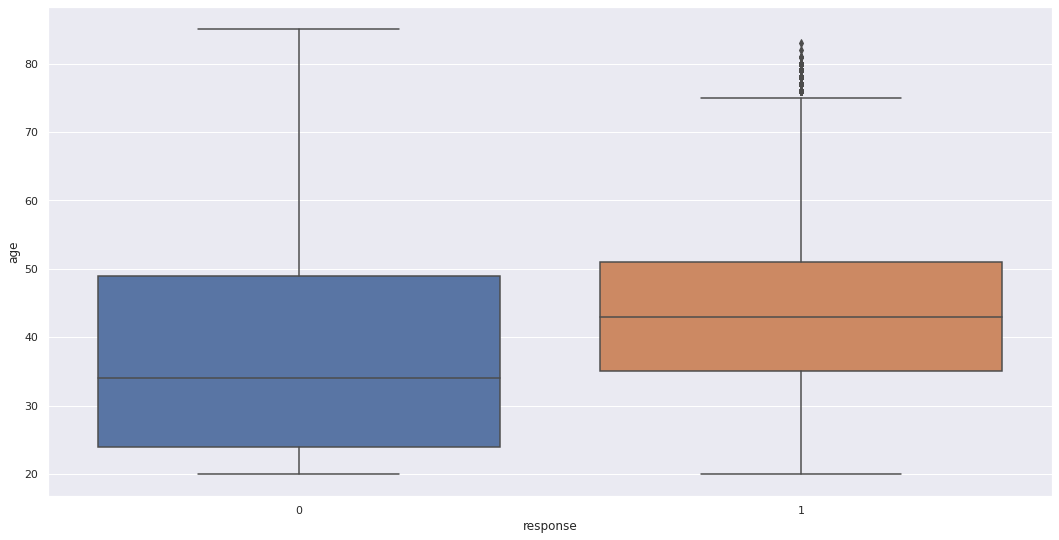

In [19]:
# age
sns.boxplot(x='response', y='age', data=df4)

<AxesSubplot:xlabel='driving_license', ylabel='response'>

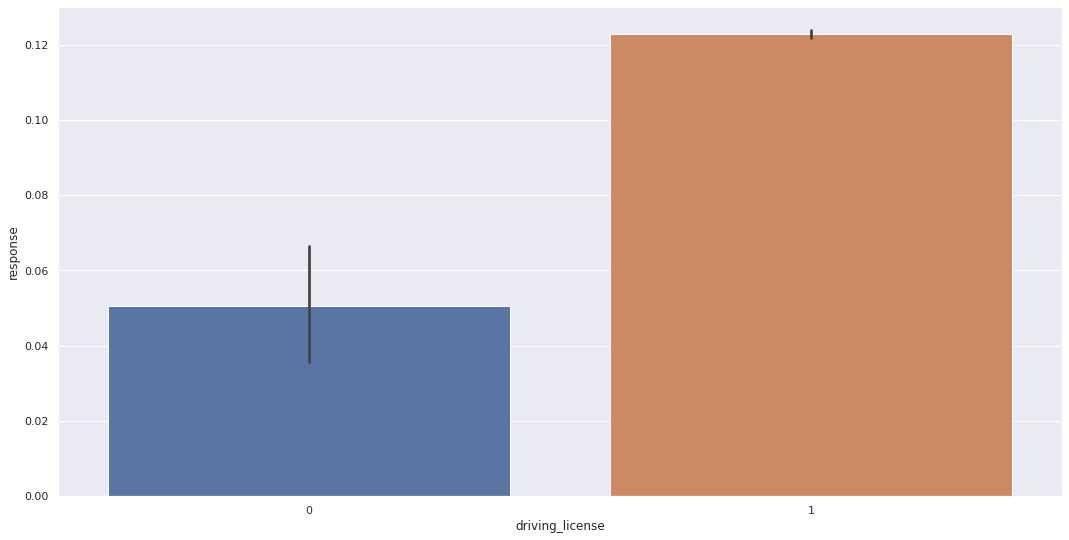

In [20]:
# driving licence
sns.barplot(x='driving_license', y='response', data=df4)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

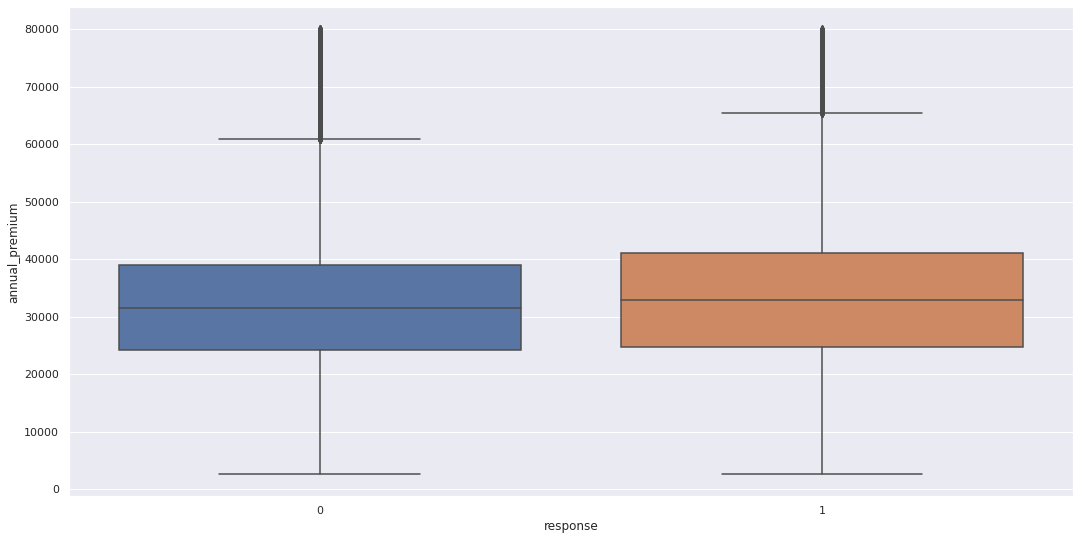

In [21]:
#annual_premium
aux0 = df4[df4['annual_premium'] <= 80000]
sns.boxplot(x='response', y='annual_premium', data=aux0)


<AxesSubplot:xlabel='region_code', ylabel='id'>

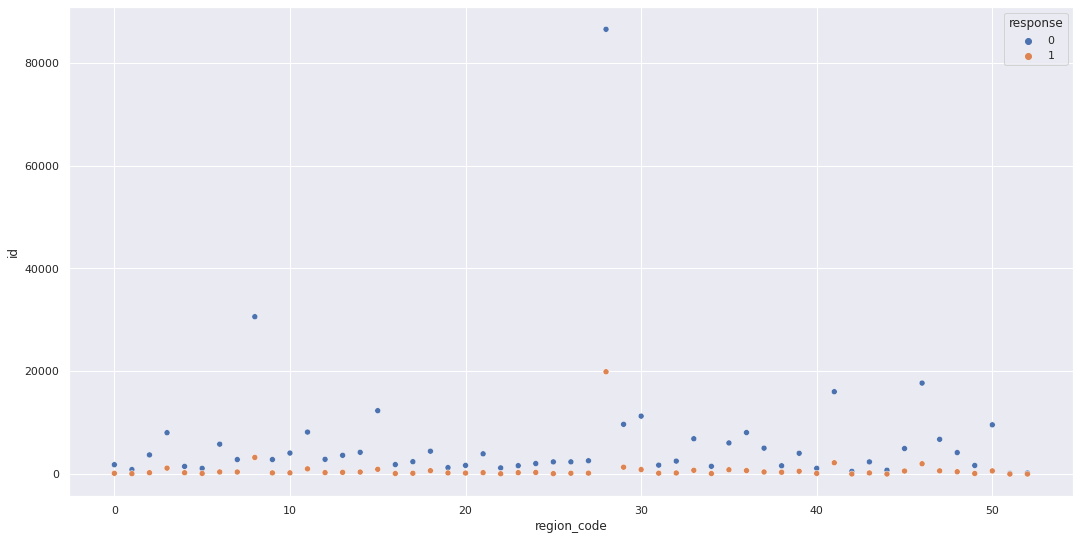

In [22]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [23]:
#previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.775,0.225
1,0.999,0.001


In [24]:
#vehicle age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434
1,bellow_1_year,0,0.413
2,between_1_2_year,1,0.091
3,over_2_years,0,0.030
4,bellow_1_year,1,0.019
5,over_2_years,1,0.012


<AxesSubplot:xlabel='response', ylabel='vintage'>

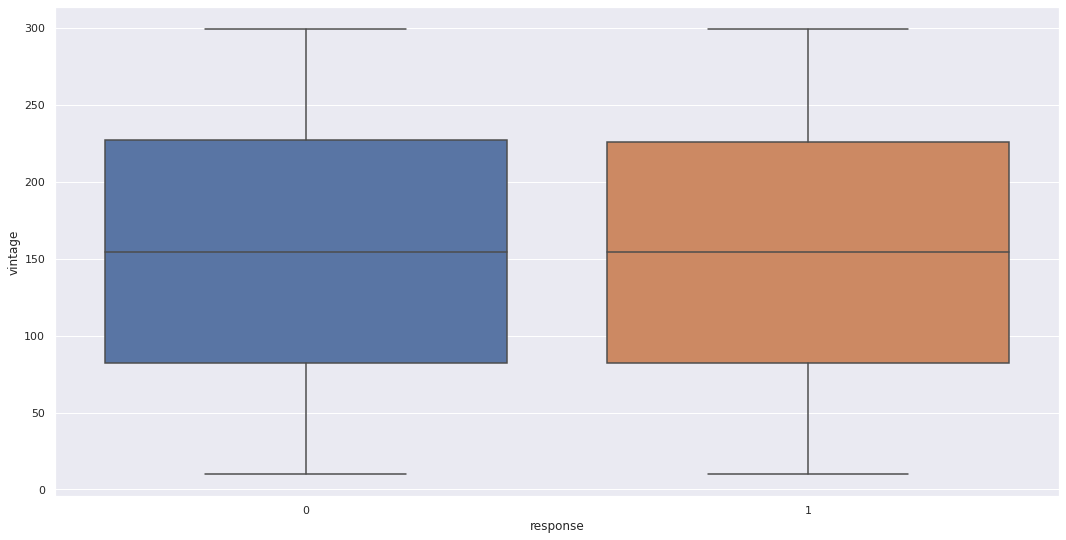

In [25]:
#vintage
sns.boxplot(x='response', y='vintage', data=df4)

## 4.2 Bivariate Analysis

### 1 - Homens são mais propensos a comprar seguro do carro do que as mulheres

***VERDADEIRO*** - conforme gráfico abaixo, homens tendem a se interessar mais pelo seguro do automóvel do que as mulheres

<AxesSubplot:xlabel='gender', ylabel='response'>

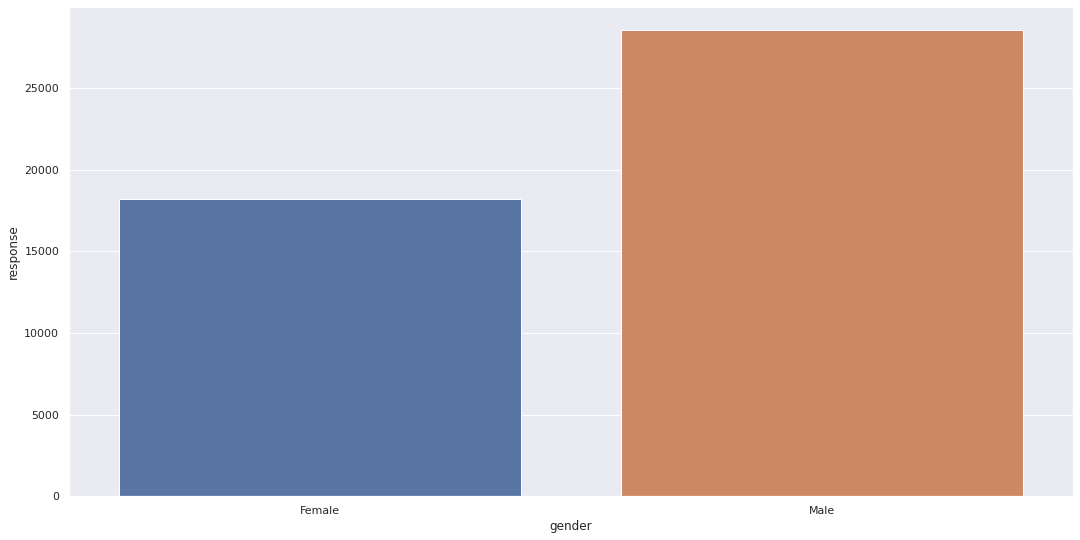

In [26]:
aux1 = df4[df4['response'] == 1]
aux = aux1[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot(x='gender', y='response', data=aux)

### 2 - Pessoas acima de 40 anos são mais propensos a comprar o seguro do carro
***VERDADEIRO*** - Conforme gráfico abaixo, pessoas acima de 40 anos são mais propensos a se interessar pelo seguro do carro que menores de 40 anos

/tmp/ipykernel_3879/87381041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['age'] = aux1['age'].apply(lambda x: '> 40' if x >= 40 else '< 40')


<AxesSubplot:xlabel='age', ylabel='response'>

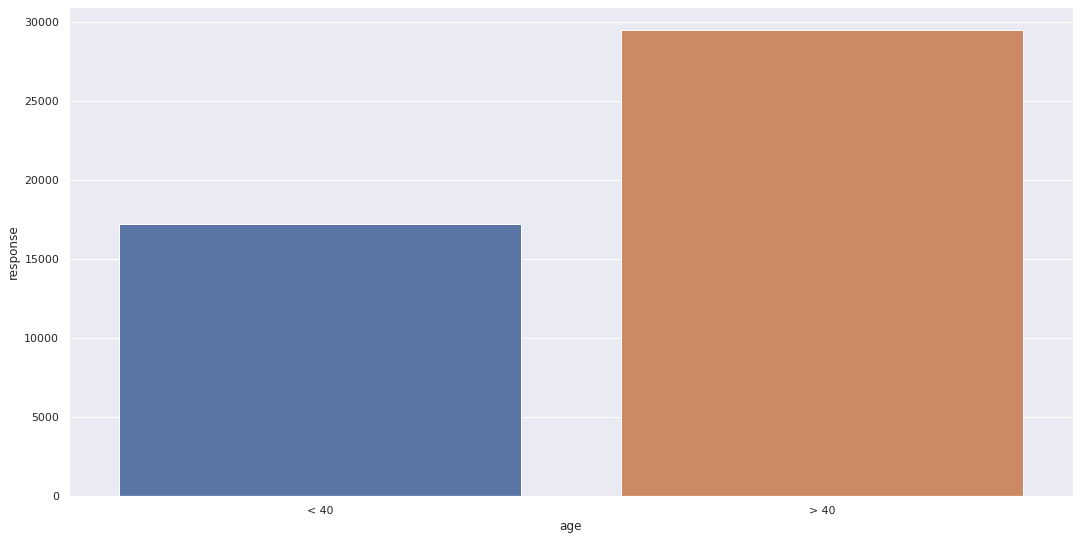

In [27]:
aux1 = df4[df4['response'] == 1]
aux1['age'] = aux1['age'].apply(lambda x: '> 40' if x >= 40 else '< 40')
aux2 = aux1[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux2)

### 3 - Pessoas que pagam mais de 50k por ano em seguro saúde são mais propensos a comprar também o seguro do carro
***FALSO*** - De acordo com os dados, não temos evidências que pessoas que gastam mais de 50k por ano em seguro saúde tem mais chances de adquirir o seguro do automóvel em relação a quem gasta menos que 50k por ano

<AxesSubplot:xlabel='annual_premium', ylabel='response'>

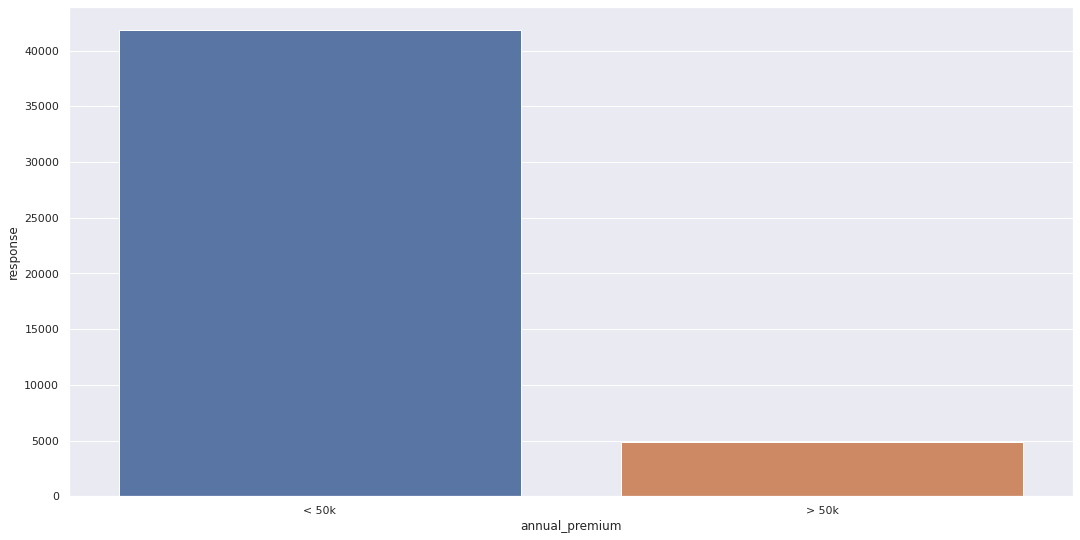

In [28]:
aux = df4[['annual_premium', 'response']][df4['response'] == 1].copy()
aux['annual_premium'] =  aux['annual_premium'].apply(lambda x: '> 50k' if x >= 50000 else '< 50k')
aux1 = aux[['annual_premium', 'response']].groupby('annual_premium').sum().reset_index()
aux1
sns.barplot(x='annual_premium', y='response', data=aux1)

### 4 - Homens de até 30 anos não tendem a se interessar pelo seguro do carro em média
***VERDADEIRO*** - Homens de até 30 anos tem um interesse significativamente menor em adquirir o seguro do carro em comparação a maiores de 30 anos

In [29]:
aux = df4[['age','gender', 'response']][df4['gender'] == 'Male' ][df4['response'] == 1]
aux['age'] = aux['age'].apply(lambda x: '<= 30' if x <= 30 else '> 30')
aux1 = aux[['age', 'response']].groupby('age').sum().reset_index()
aux1

/tmp/ipykernel_3879/3687861998.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aux = df4[['age','gender', 'response']][df4['gender'] == 'Male' ][df4['response'] == 1]
/tmp/ipykernel_3879/3687861998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['age'] = aux['age'].apply(lambda x: '<= 30' if x <= 30 else '> 30')


,age,response
0,<= 30,3942
1,> 30,24583


<AxesSubplot:xlabel='age', ylabel='response'>

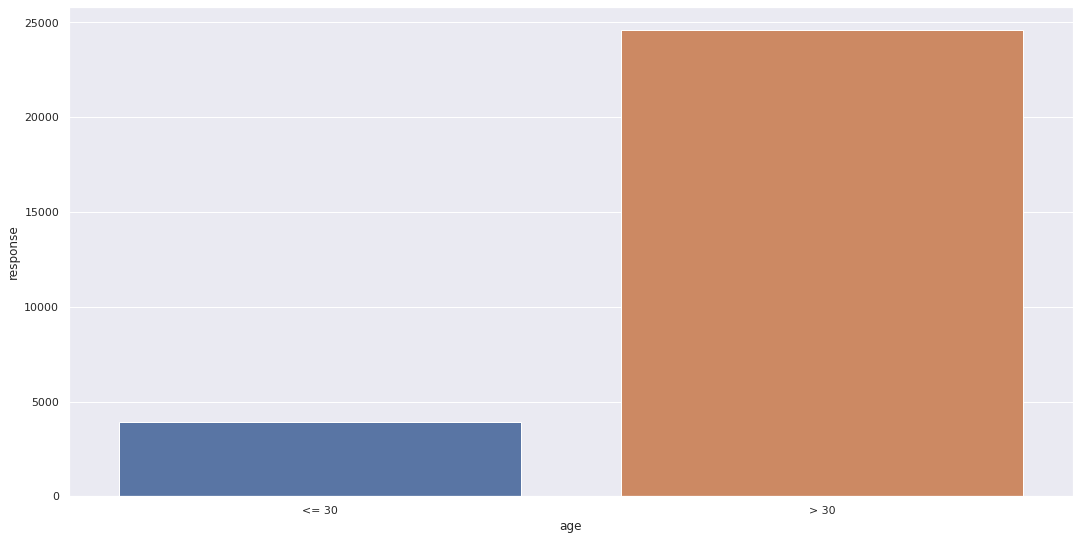

In [30]:
sns.barplot(x='age', y='response', data=aux1)

### 5 - Donos de carros cujo a idade do veículo é menor que  1 ano tendem a comprar o seguro de carro
***FALSO*** - Donos de carros com idade entre 1 e 2 anos tendem a ter mais interesse do que donos de automóveis com idade inferior a 1 ano

In [31]:
aux = df4[['vehicle_age','response']][df4['response'] == 1]
aux1 = aux.groupby('vehicle_age').sum().reset_index()
aux1

,vehicle_age,response
0,bellow_1_year,7202
1,between_1_2_year,34806
2,over_2_years,4702


<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

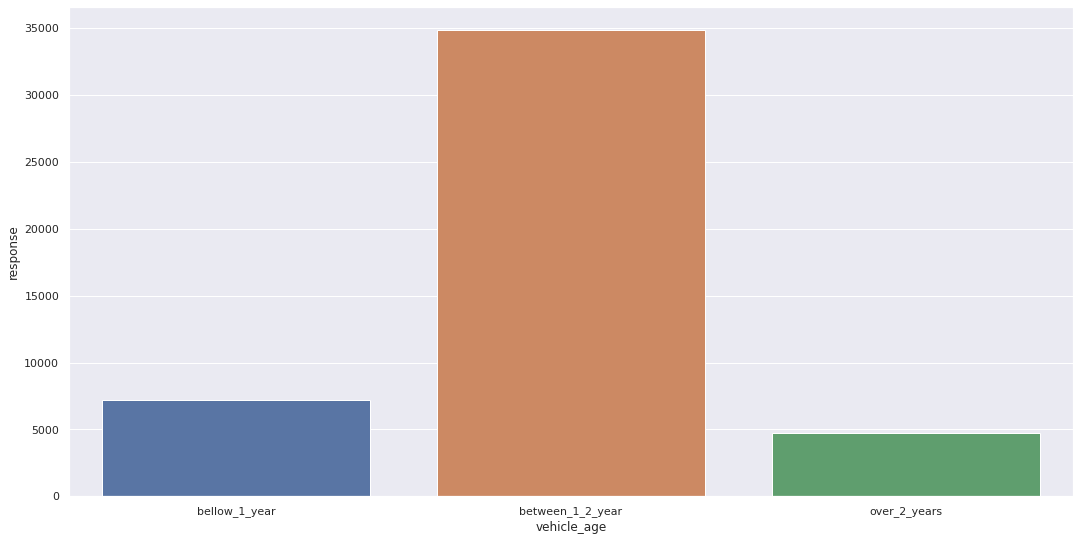

In [32]:
sns.barplot(x='vehicle_age', y='response', data=aux1)

### 6 - Clientes há mais de 100 dias do seguro saúde tendem a ter interesse no seguro do carro
**VERDADEIRO** - Clientes que possuem seguro saúde há mais de 100 dias possuem maior interesse em adquirir o seguro do automóvel

<AxesSubplot:xlabel='vintage', ylabel='response'>

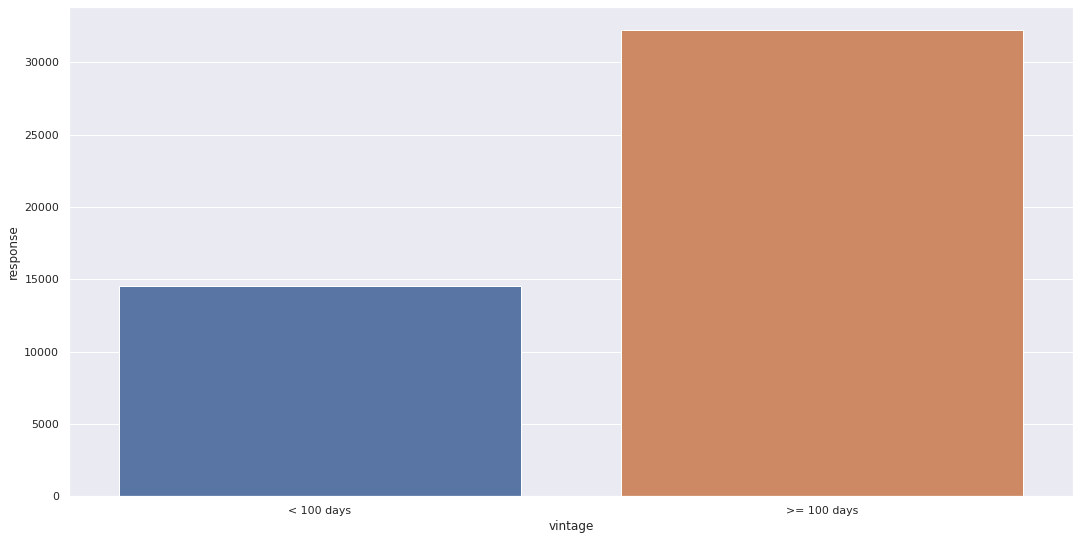

In [42]:
aux = df4[df4['response'] == 1].copy()
aux['vintage'] = df4['vintage'].apply(lambda x: '>= 100 days' if x >= 100 else '< 100 days') 
aux1 = aux[['vintage', 'response']].groupby('vintage').sum().reset_index()
sns.barplot(x='vintage', y='response', data=aux1)

### 7 - Homens com mais de 50 anos que nunca tiveram seguro de carro não tendem a ter interesse
**VERDADEIRO** - Conforme vemos na tabela abaixo, clientes com mais de 50 anos e que nunca tiveram um seguro de carro, não tendem a ter interesse em adquirir o seguro após essa idade

In [50]:
aux = df4.copy()
aux['age'] = aux['age'].apply(lambda x: '>=_50_years' if x >= 50 else '<_50_years')
aux1 = aux[['age', 'response', 'previously_insured']].groupby(['age', 'previously_insured']).count().reset_index()
aux1

,age,previously_insured,response
0,<_50_years,0,142886
1,<_50_years,1,143416
2,>=_50_years,0,63595
3,>=_50_years,1,31212


### 8 - Clientes que pagam até 30 mil de seguro saúde por ano não tendem a ter interesse no seguro do carro
**FALSO** Como percebemos no gráfico abaixo, o valor que se paga no seguro saúde não determina se a pessoa terá interesse ou não em adquirir o seguro do carro

<AxesSubplot:xlabel='annual_premium', ylabel='response'>

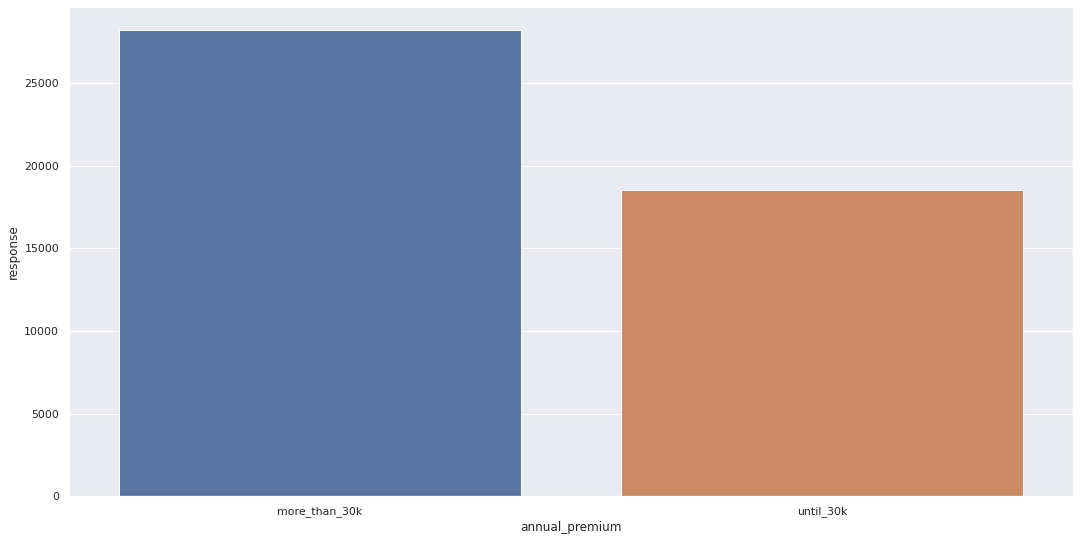

In [53]:
aux = df4[['annual_premium', 'response']][df4['response'] == 1].copy()
aux['annual_premium'] =  aux['annual_premium'].apply(lambda x: 'until_30k' if x <= 30000 else 'more_than_30k')
aux1 = aux[['annual_premium', 'response']].groupby('annual_premium').sum().reset_index()
aux1
sns.barplot(x='annual_premium', y='response', data=aux1)

## 4.3 Analise Multivariada


### 4.3.1 Numerical Attributes 

<AxesSubplot:>

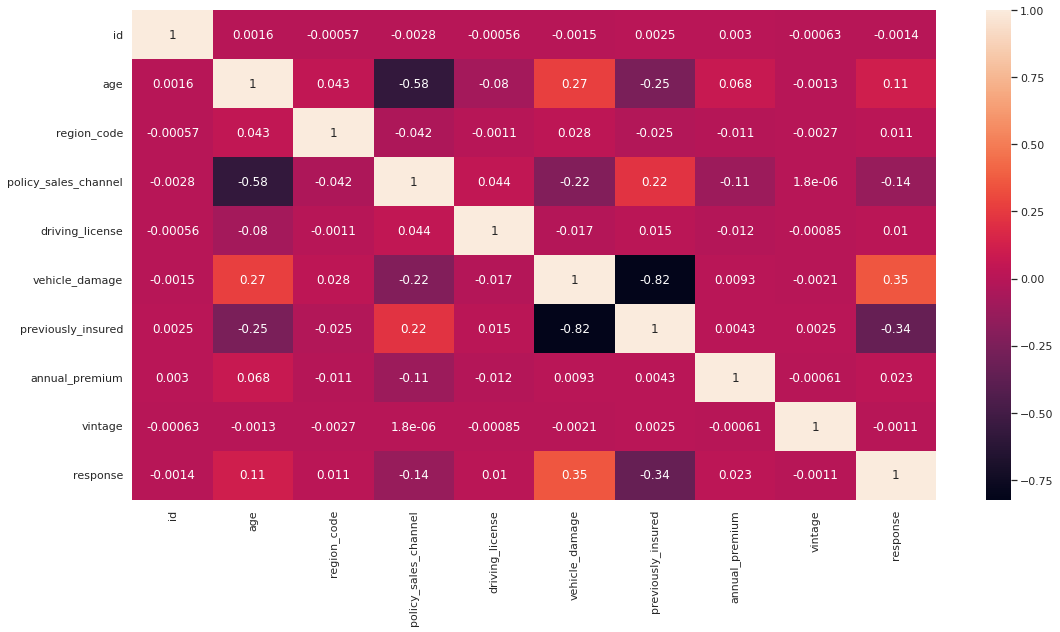

In [54]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.1 Categorical Attributes


In [56]:
a = df4.select_dtypes(include='object')

In [59]:
a.head()

,gender,vehicle_age
0,Male,bellow_1_year
1,Female,between_1_2_year
2,Female,bellow_1_year
3,Female,bellow_1_year
4,Male,between_1_2_year


In [63]:
#utlizando método de cramer para verificar a correlação entre variáveis categóricas

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])


d = pd.DataFrame({'gender': [a1,a2],
              'vehicle_age': [a4,a5]})

d = d.set_index(d.columns)

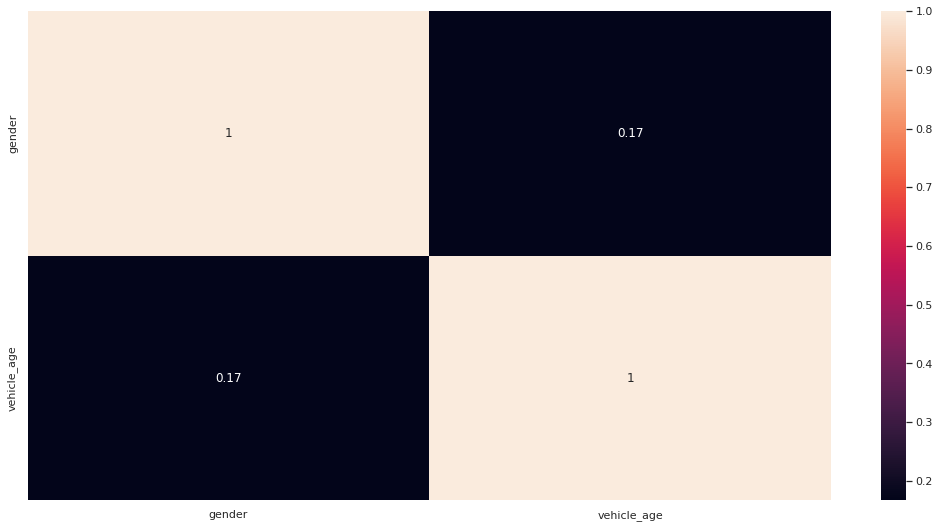

In [64]:
sns.heatmap(d, annot=True);


# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

## Standardzation

In [71]:
ssc = pp.StandardScaler()

# annual premium
df5['annual_premium'] = ssc.fit_transform(df5[['annual_premium']].values)

## Rescaling

In [74]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage 
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## Encoder

In [77]:
# region code - Target Encode
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding  
df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])

# policy_sales_channel - Frequency Encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

In [78]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
0,7,Male,0.046,0.113,0.354,1,1,0,-0.418,0.827,0,1,0,0
1,13,Female,0.323,0.072,0.002,1,0,1,0.049,0.730,0,0,1,0
2,18,Female,0.077,0.125,0.354,1,0,1,0.933,1.000,0,1,0,0
3,31,Female,0.092,0.096,0.057,1,0,0,-1.623,0.436,0,1,0,0
4,39,Male,0.385,0.096,0.194,1,1,0,0.682,0.879,0,0,1,0
